In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data_collector import Omie

from potenciala import BucketMethod, SingleTimeSeries, VectorTimeSeries

In [3]:
# uncomment this to obtain most up-to-date day ahead market timeseries
#df = Omie.download_period_file(filename="marginalpdbc", start_year=2016, end_year=2021)
#df = Omie.include_old_file(df=df, filename="marginalpdbc_2002_2015.csv")

In [4]:
df = pd.read_csv("day_ahead_market_20210903.csv")

### Decide x_value resolution: 0.25 or 1
### Issue with time change: 23, 24 and 25 hours -> Solved through no_time_change parameter

In [5]:
s_1 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Round, bin_size=1)
s_025 = SingleTimeSeries(df=df, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)

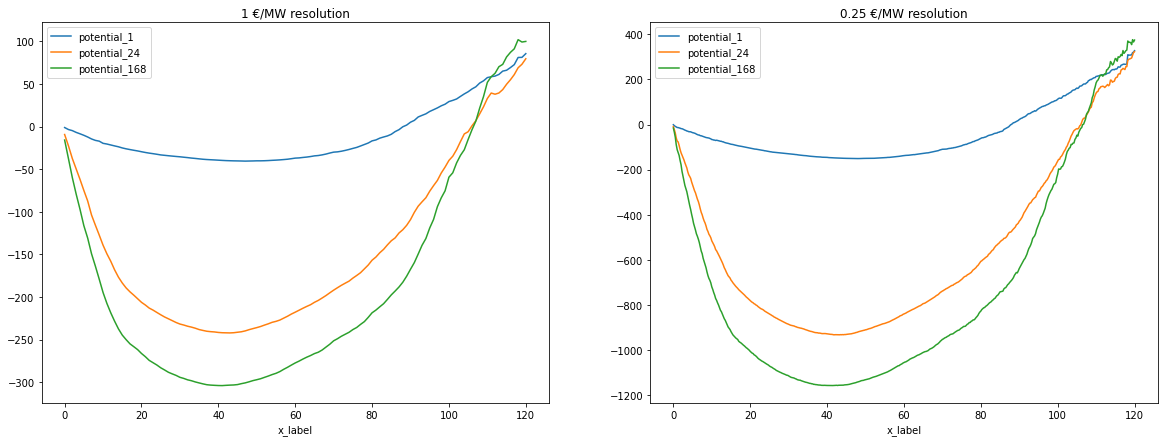

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))
s_1.potential.loc[:120].plot(ax=ax0)
s_025.potential.loc[:120].plot(ax=ax1)
ax0.set_title("1 €/MW resolution")
ax1.set_title("0.25 €/MW resolution")
plt.show()

### Include all history or last n years

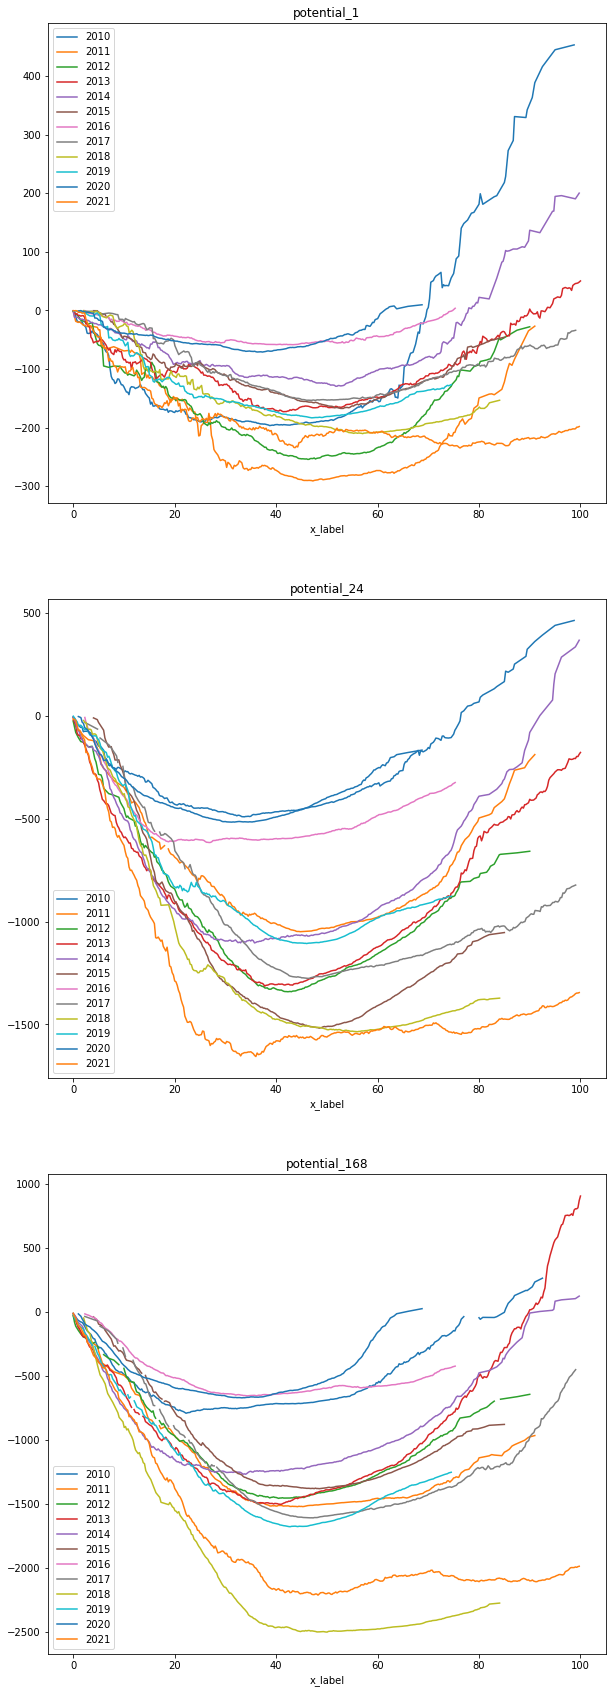

In [7]:
# Compare potential across different years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

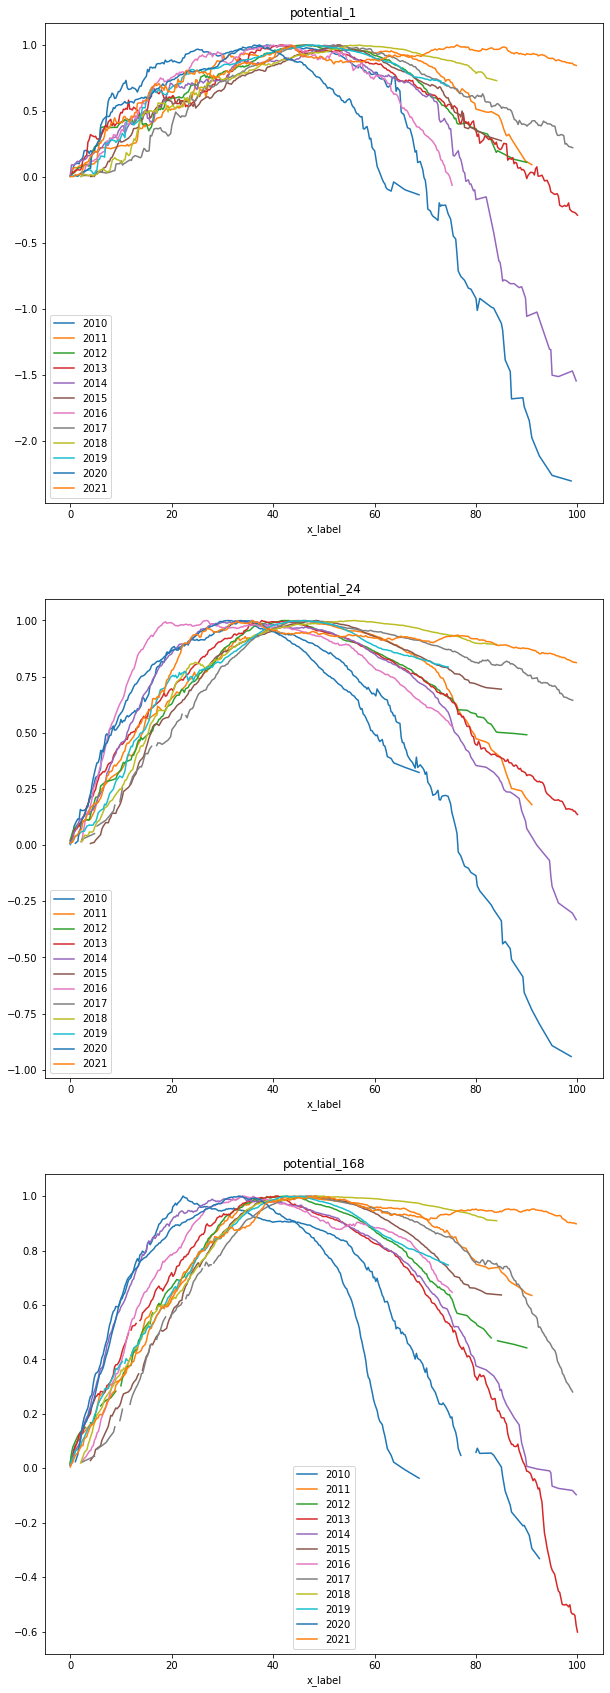

In [8]:
# Compare potential across different years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
for year in years:
    df_year = df[df["year"] == year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

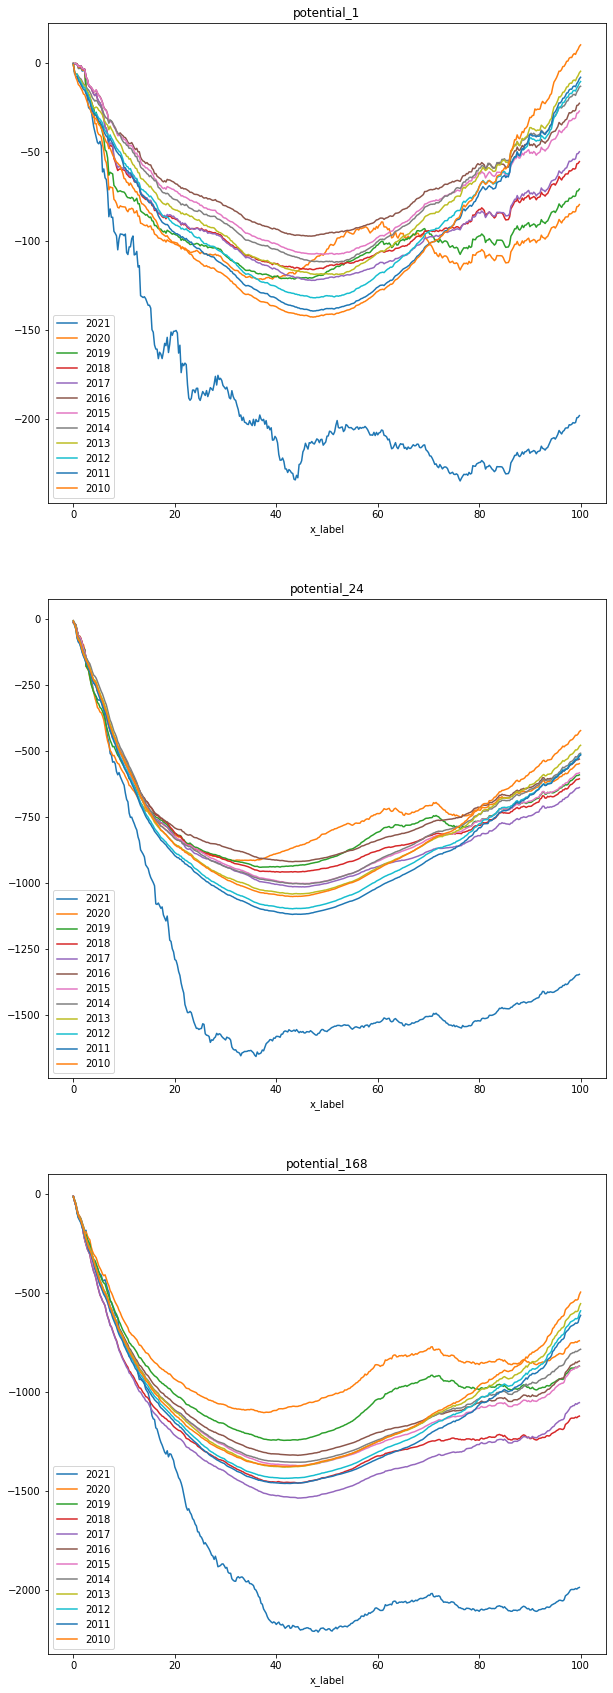

In [9]:
# Compute accumulative years
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

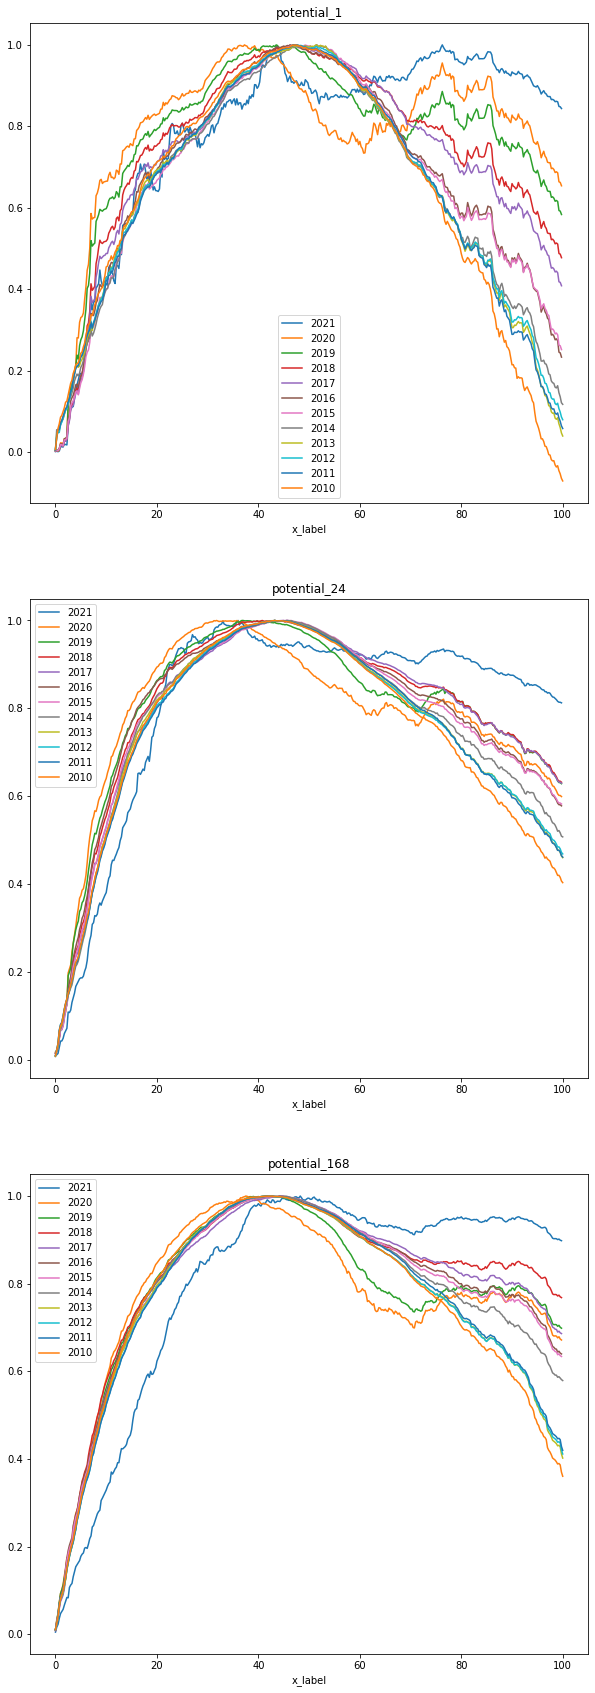

In [10]:
# Compute accumulative years with minimum
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2010, 2022)
years = years[::-1]
for year in years:
    df_year = df[df["year"] >= year]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

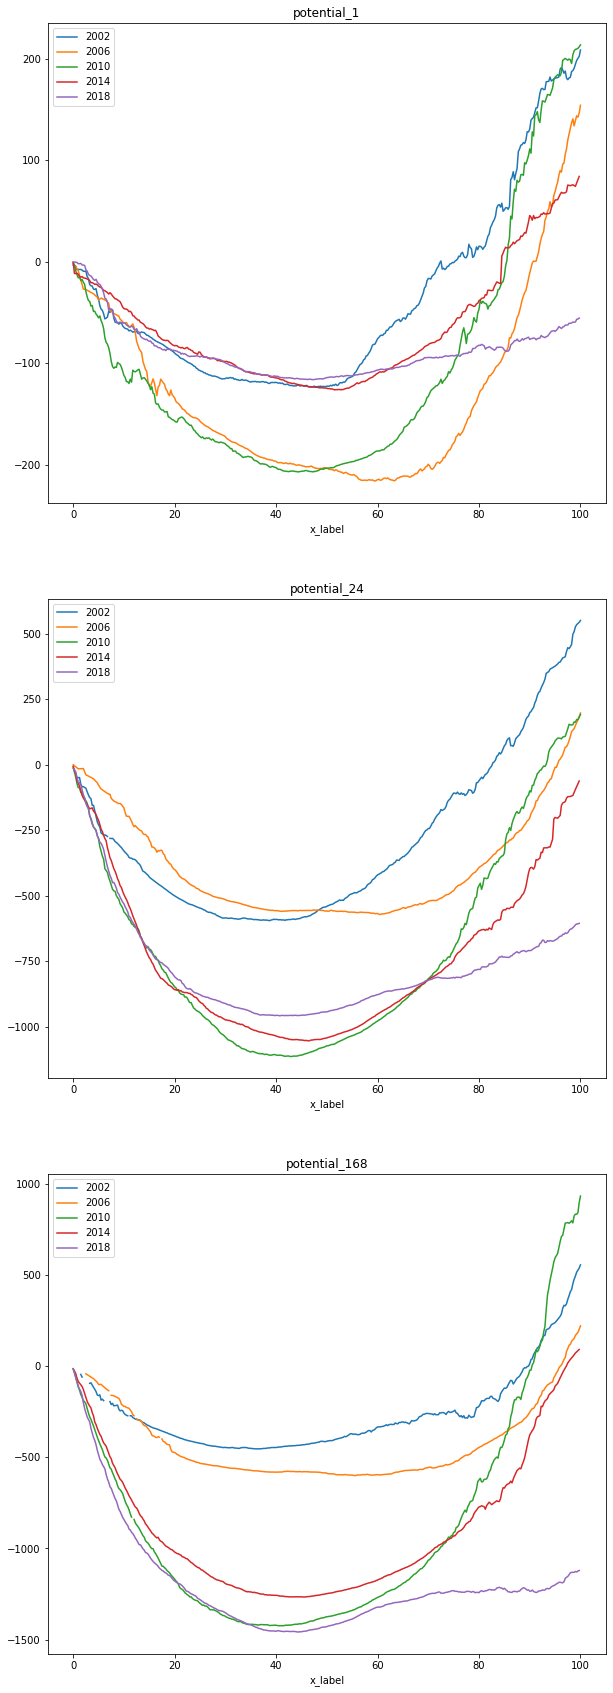

In [11]:
# Check n-year period
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        s_year.potential[col].loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

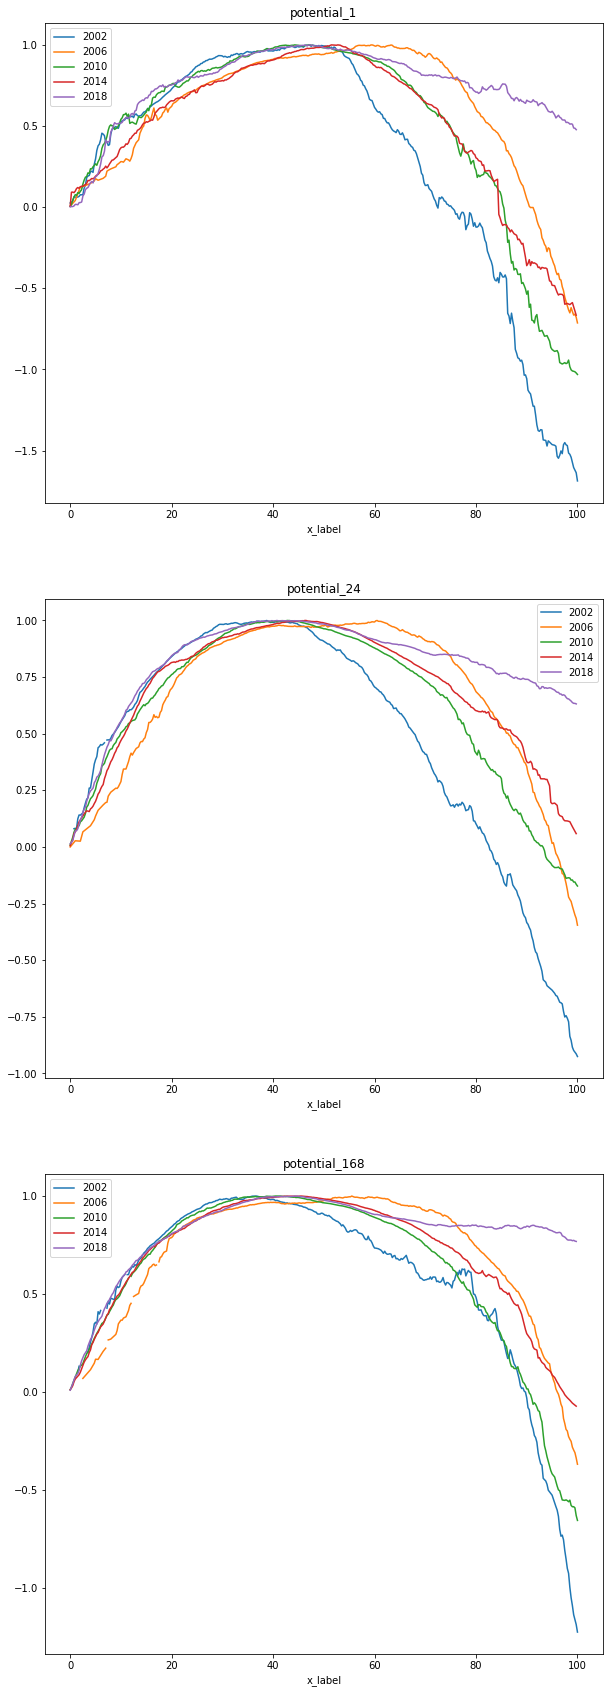

In [12]:
# Check n-year period divided by minimum
n = 4
fig, axis = plt.subplots(3, 1, figsize=(10, 30))
years = range(2002, 2022, n)
for year in years:
    df_year = df[(df["year"] >= year) & (df["year"] < year + n)]
    s_year = SingleTimeSeries(df=df_year, signal_name="spain", metric_lag_time=[1, 24, 168], bucket_method=BucketMethod.Cut, bin_size=0.25)
    for ax, col in zip(axis, s_year.potential_cols):
        (s_year.potential[col] / s_year.potential[col].min()).loc[:100].plot(ax=ax)
for ax, col in zip(axis, s_year.potential_cols):
    ax.legend(years)
    ax.set_title(col)

### Ito stochastic differential equation (SDE)

An Ito process $X = \{X_t, t \ge 0\}$ has the form
$$ 
    X_t = X_0 + \int_{0}^{t} a(X_s)ds + \int_{0}^{t}b(X_s)dW_s
$$ \
for $t \ge 0$. In differential (SDE) form
$$ 
    dX_t = a(X_t)dt + b(X_t)dW_t
$$ \
where $a$ is called the *drift* of the diffusion process and $b$ the *diffusion coefficient*. $W$ is a Wiener process $W = \{W_t, t \ge 0\}$.
\
\
Consider a time discretisation $(\tau)_{\delta}$ of a time interval $[0, T]$ with
$$ 
    0 = \tau_0 < \tau_1 < \cdots < \tau_n < \cdots < \tau_N = T
$$
\
where the step size is
$$
    \delta = \frac{T}{N}
$$
\
The *Euler-Maruyama approximation* for the SDE
$$ 
    Y_{n+1} = Y_n + a(Y_n)\Delta_{n} + b(Y_n)\Delta W_n
$$
\
for $ n = 0, 1, ..., N-1 $ with initial value
$$ 
    Y_0 = x_0
$$
\
where 
\begin{align}
    \Delta_n &= \tau_{n+1} - \tau_{n} = \delta \\
    \Delta W_{n} &= W_{\tau_{n+1}} - W_{\tau_{n}} \quad \Delta W_{n} \sim N(0;\Delta_{n})
\end{align}


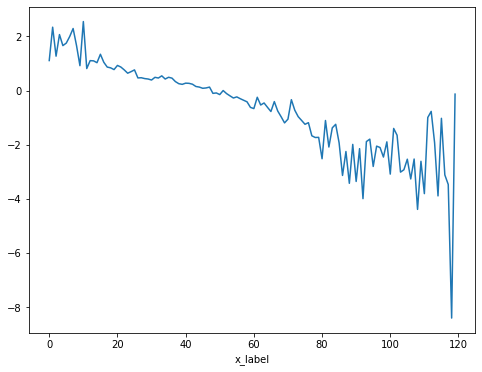

In [13]:
# plot mean drift and diffusion
_ = s_1.drift.mean["drift_1"].iloc[:120].plot()

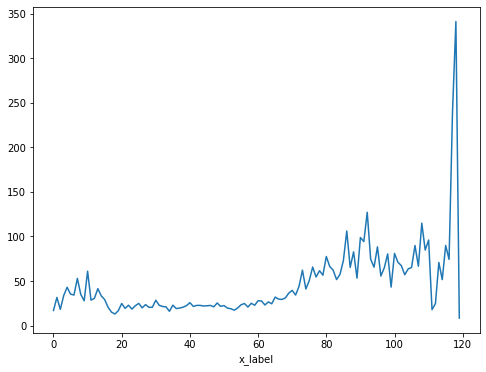

In [14]:
_ = s_1.diffusion.mean["diffusion_1"].iloc[:120].plot()

In [15]:
a = s_1.drift.mean["drift_1"]
b = s_1.diffusion.mean["diffusion_1"]

In [16]:
x_df = s_1.df[(s_1.df["date"] >= "2021-03-01")].iloc[:48]
y_0 = x_df["spain"].iloc[0]

In [17]:
# first draft: simulate n paths
np.random.seed(seed=72)
n = 1000
T = 48
delta = 1
nu = 0
sim_df = pd.DataFrame()
for i in range(n):
    y = np.zeros(48)
    y[0] = y_0
    for t in range(1, T):
        y_t_1 = y[t-1]
        y_t_1_round = y_t_1.round()
        y[t] = y_t_1 + a.loc[y_t_1_round]*delta + np.sqrt(b.loc[y_t_1_round])*np.random.normal(loc=nu, scale=delta)
        if y[t] < 0:
            y[t] = 0
    sim_df[i] = y

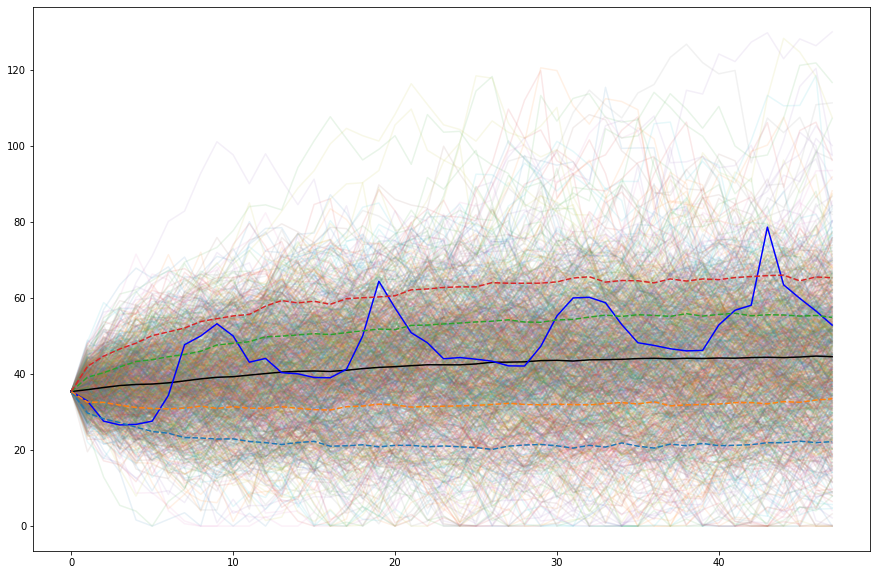

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
sim_df.plot(alpha=0.1, ax=ax, legend=False)
sim_df.mean(axis=1).plot(lw=1.5, color="black", ax=ax)
x_df.reset_index()["spain"].plot(lw=1.5, color="blue", ax=ax)
sim_df.quantile(q=[0.1, 0.25, 0.75, 0.9], axis=1).T.plot(lw=1.5, ls="--", ax=ax, legend=False)
plt.show()

### Vector approach

In [19]:
s = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.Round, bin_size=1)

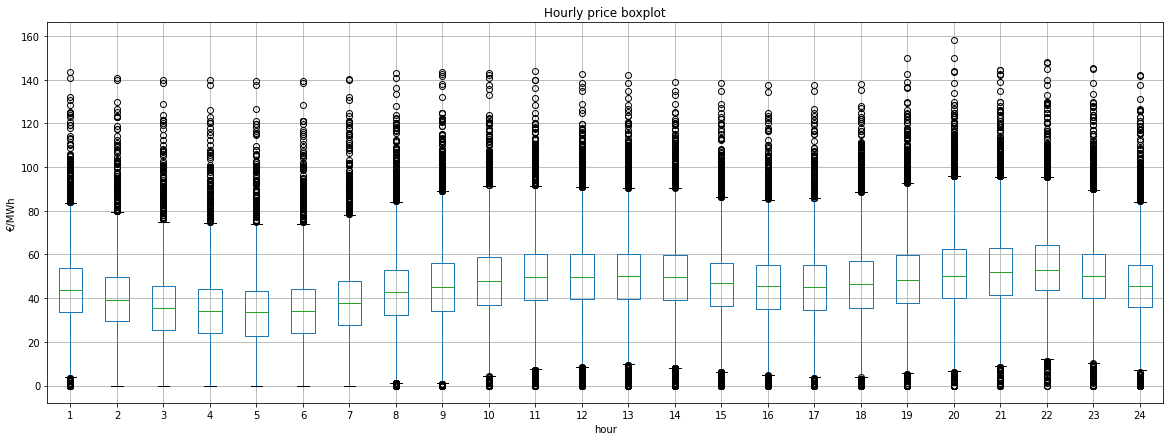

In [20]:
s.plot_hourly_boxplot()

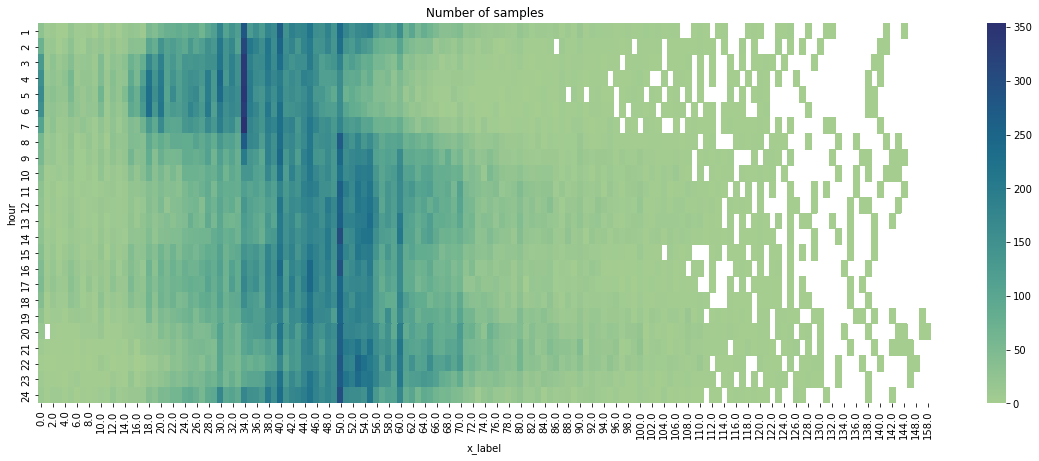

In [21]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.samples_hour_x, ax=ax, cmap='crest')
ax.set_title("Number of samples")
fig.show()

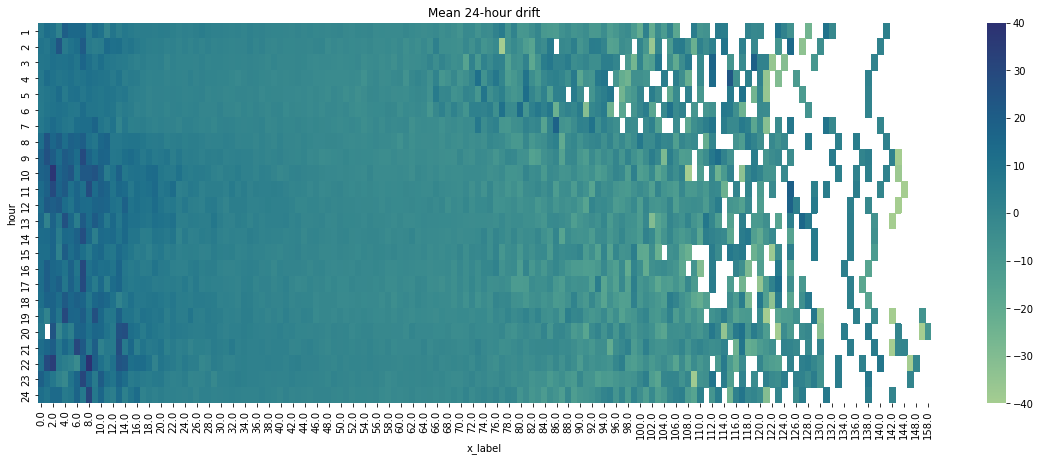

In [22]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.drift_hour_x, ax=ax, cmap='crest', vmin=-40, vmax=40)
ax.set_title("Mean 24-hour drift")
fig.show()

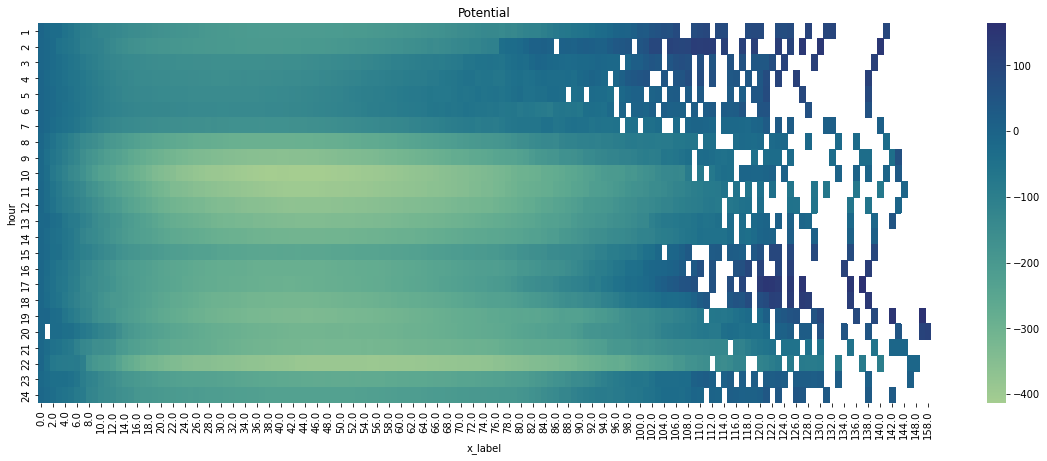

In [23]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(s.potential_hour_x, ax=ax, cmap='crest')
ax.set_title("Potential")
fig.show()

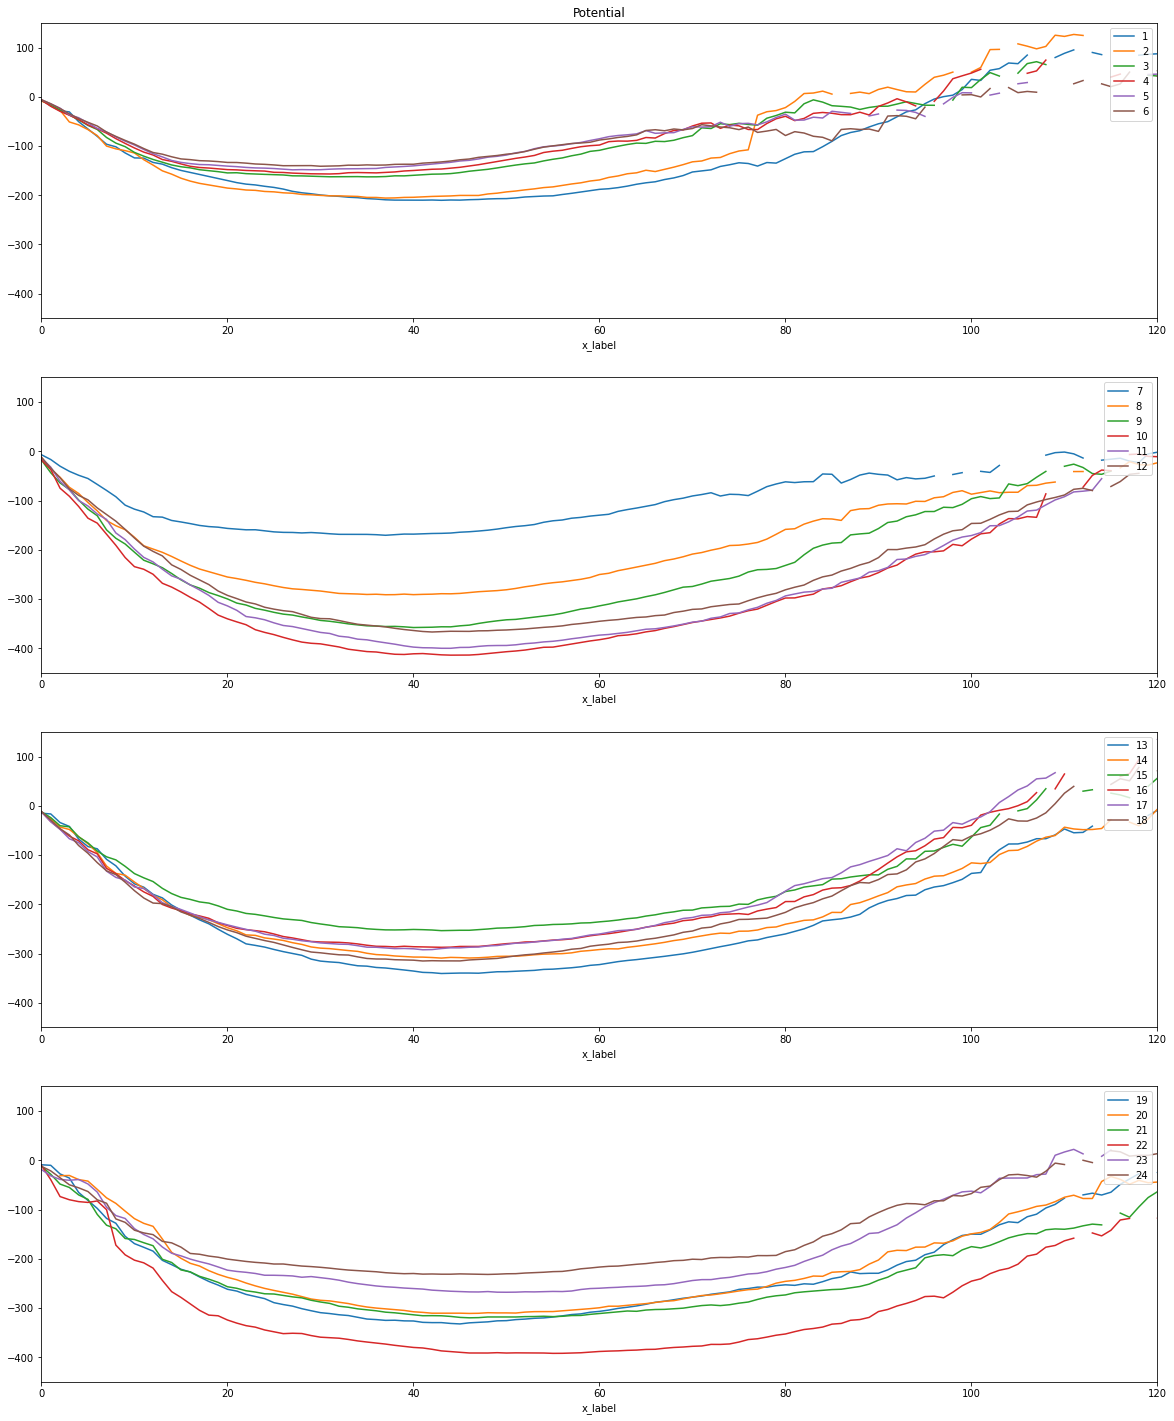

In [24]:
m = 6
n = int(24/m)
fig, ax = plt.subplots(n, 1, figsize=(20, 25))
for i in range(n):
    s.potential_hour_x.loc[i*m+1:(i+1)*m].T.plot(ax=ax[i])
    ax[i].legend(loc=1)
    ax[i].set_xlim(0, 120)
    ax[i].set_ylim(-450, 150)
ax[0].set_title("Potential")
fig.show()